# Fetch Rewards Machine Learning Take Home for Michael Gathara

I take a typical approach of 
- loading the data 
- Finding out about the data, using Data Analysis
- Normalizing the data
- Splitting between our training and validation data
- Actually defining our model, I will use a PyTorch Neural Network for this. Although a bit overkill 
- Training our model
- Eval our data
- Save our model for inference

In [67]:
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import joblib

Loading the data, making it more actionable

In [68]:
"""
This script performs several data preprocessing steps to load and aggregate daily receipt data into monthly sums.

Steps:
1. Read the daily receipt data from a CSV file located at "../data/data_daily.csv" into a Pandas DataFrame.
2. Convert the '# Date' column to a Pandas datetime object for easier date manipulation.
3. Create a new column 'Year-Month' that represents the year and month of each entry, effectively truncating the day.
4. Group the data by this new 'Year-Month' column and sum up the 'Receipt_Count' for each group, resulting in a new DataFrame that holds aggregated monthly receipt data.

Variables:
- data: A Pandas DataFrame that holds the daily receipt data. Columns include '# Date' and 'Receipt_Count'.
- data_monthly: A Pandas DataFrame that holds the aggregated monthly receipt data. Columns include 'Year-Month' and the summed 'Receipt_Count'.

Example:
---------
If the daily data is:
    # Date       Receipt_Count
    2021-01-01   1000
    2021-01-02   1500
    2021-02-01   2000

The resulting monthly data (data_monthly) would be:
    Year-Month   Receipt_Count
    2021-01      2500
    2021-02      2000
"""
data = pd.read_csv("../data/data_daily.csv")
data['# Date'] = pd.to_datetime(data['# Date'])
data['Year-Month'] = data['# Date'].dt.to_period('M')
data = data.groupby('Year-Month').agg({'Receipt_Count': 'sum'}).reset_index()

data

,Year-Month,Receipt_Count
0,2021-01,236736687
1,2021-02,220033460
2,2021-03,248608625
3,2021-04,250644830
4,2021-05,263151748
5,2021-06,260656840
6,2021-07,274776003
7,2021-08,283943231
8,2021-09,281146154
9,2021-10,295965185


Data Visulization 

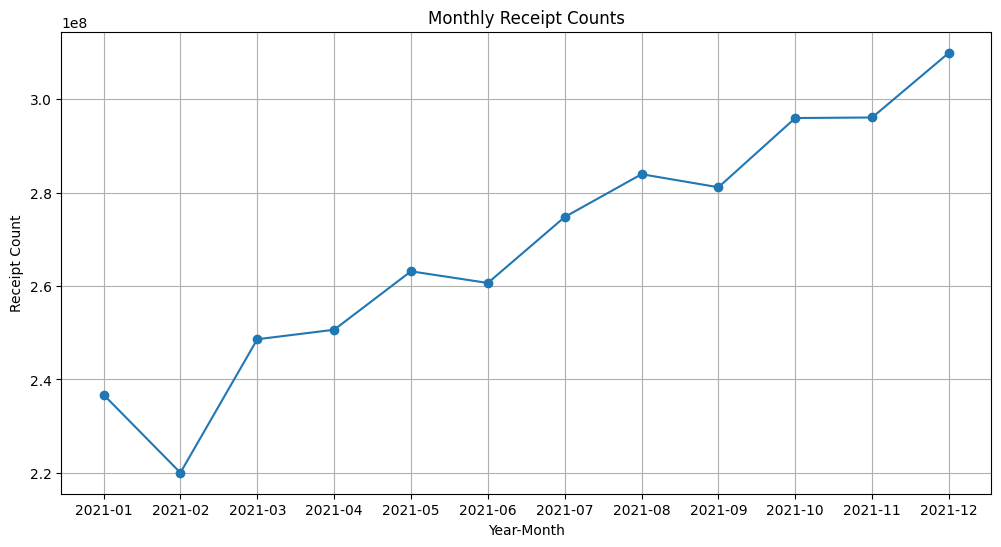

count    1.200000e+01
mean     2.684747e+08
std      2.668601e+07
min      2.200335e+08
25%      2.501358e+08
50%      2.689639e+08
75%      2.869487e+08
max      3.099487e+08
Name: Receipt_Count, dtype: float64


In [69]:

plt.figure(figsize=(12, 6))
plt.plot(data['Year-Month'].astype(str), data['Receipt_Count'], marker='o')
plt.title('Monthly Receipt Counts')
plt.xlabel('Year-Month')
plt.ylabel('Receipt Count')
plt.grid(True)
plt.show()
print(data['Receipt_Count'].describe())


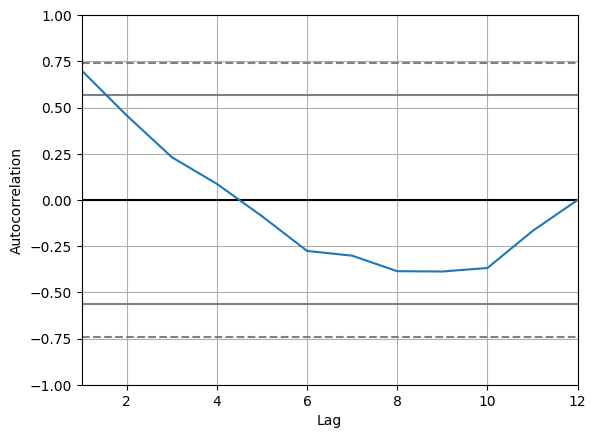

In [70]:

autocorrelation_plot(data['Receipt_Count'])
plt.show()


Normalization

In [71]:
"""
This script performs data normalization on the 'Receipt_Count' column of the daily receipt data.

Normalization is achieved using the MinMaxScaler from scikit-learn, which scales the data to a specified range, in this case, between 0 and 1.

Steps:
1. Initialize the MinMaxScaler with the feature range of 0 to 1.
2. Extract the 'Receipt_Count' values from the DataFrame and reshape it into a 2D array.
3. Fit and transform the 'Receipt_Count' values using the initialized scaler.
4. Add the scaled values back to the DataFrame in a new column called 'Scaled_Receipt_Count'.

Variables:
- scaler: An instance of MinMaxScaler initialized with feature range 0 to 1.
- receipt_count: A 2D array containing the 'Receipt_Count' values from the DataFrame.
- scaled_receipt_count: A 2D array containing the scaled 'Receipt_Count' values.
- data: The original DataFrame, now updated with a new column 'Scaled_Receipt_Count' that contains the normalized values.

Example:
--------
If the original 'Receipt_Count' is:
    Receipt_Count
    1000
    2000
    3000

The resulting 'Scaled_Receipt_Count' would be:
    Scaled_Receipt_Count
    0.0
    0.5
    1.0
"""
scaler = MinMaxScaler(feature_range=(0, 1))
receipt_count = data['Receipt_Count'].values.reshape(-1, 1)

scaled_receipt_count = scaler.fit_transform(receipt_count)
data['Scaled_Receipt_Count'] = scaled_receipt_count

data

,Year-Month,Receipt_Count,Scaled_Receipt_Count
0,2021-01,236736687,0.185766
1,2021-02,220033460,0.000000
2,2021-03,248608625,0.317801
3,2021-04,250644830,0.340447
4,2021-05,263151748,0.479544
5,2021-06,260656840,0.451796
6,2021-07,274776003,0.608824
7,2021-08,283943231,0.710778
8,2021-09,281146154,0.679670
9,2021-10,295965185,0.844481


Splitting the data

In [72]:
splitIdx = int(len(data) * 0.8)

trainData = data[:splitIdx]
valData = data[splitIdx:]

trainData

,Year-Month,Receipt_Count,Scaled_Receipt_Count
0,2021-01,236736687,0.185766
1,2021-02,220033460,0.000000
2,2021-03,248608625,0.317801
3,2021-04,250644830,0.340447
4,2021-05,263151748,0.479544
5,2021-06,260656840,0.451796
6,2021-07,274776003,0.608824
7,2021-08,283943231,0.710778
8,2021-09,281146154,0.679670


The model, using a feed forward neural network

In [73]:
"""
This script defines and initializes a simple feed-forward neural network using PyTorch. 
It also sets up the loss function and the optimizer to be used for training the model.

Classes:
- FeedForwardNN: A class that inherits from PyTorch's nn.Module. It defines a simple two-layer feed-forward neural network.

Methods:
- __init__(self, input_dim, hidden_dim, output_dim): Initializes the network layers.
- forward(self, x): Defines the forward pass through the network.

Variables:
- input_dim: The dimensionality of the input data. For this application, it is set to 1.
- hidden_dim: The number of neurons in the hidden layer. Set to 10 in this example.
- output_dim: The dimensionality of the output data. Set to 1 in this example.
- model: An instance of the FeedForwardNN class.
- criterion: The loss function used for training the model, set to Mean Squared Error (MSE) loss.
- optimizer: The optimization algorithm used for updating the model parameters, set to Adam.

Example:
--------
- For an input x of shape (batch_size, 1), the model produces an output of shape (batch_size, 1).

"""
class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedForwardNN, self).__init__()
        
        self.layer1 = nn.Linear(input_dim, hidden_dim)
        self.layer2 = nn.Linear(hidden_dim, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.layer2(x)
        return x


input_dim = 1  
hidden_dim = 10 
output_dim = 1  

model = FeedForwardNN(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [74]:
trainTensor = torch.FloatTensor(trainData['Scaled_Receipt_Count'].values).view(-1, 1)
valTensor = torch.FloatTensor(valData['Scaled_Receipt_Count'].values).view(-1, 1)


In [75]:
"""
This script performs the training loop for the feed-forward neural network model defined earlier.

The model is trained for a fixed number of epochs, with the loss and optimizer defined earlier.
The loss values are stored in a list for further analysis or visualization.

Steps:
1. Forward pass: Compute the network's output for each sample in the training set (trainTensor).
2. Loss calculation: Compute the loss using the Mean Squared Error (MSE) criterion.
3. Backpropagation: Zero the gradients, perform backpropagation, and update the weights.
4. Loss tracking: Store the loss value for each epoch in the 'trainLosses' list.
5. Logging: Print the loss value every 50 epochs for monitoring.

Variables:
- epochs: The number of training epochs (set to 200).
- trainLosses: A list to store the training loss for each epoch.
- outputs: The model's predictions for the training set.
- loss: The computed loss value for each epoch.

Example:
--------
Output during training might look like:
    Epoch [50/200], Loss: 0.1234
    Epoch [100/200], Loss: 0.0567
    ...
"""
epochs = 200
trainLosses = []

for epoch in range(epochs):
    outputs = model(trainTensor)
    loss = criterion(outputs, trainTensor)
    
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    trainLosses.append(loss.item())
    
    if (epoch+1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')


Epoch [50/200], Loss: 0.0004
Epoch [100/200], Loss: 0.0001
Epoch [150/200], Loss: 0.0001
Epoch [200/200], Loss: 0.0000


In [76]:
"""
This script performs the evaluation of the trained feed-forward neural network model on the validation set.
It also saves the trained model and the fitted scaler to disk for later use in inference.

Steps:
1. Switch the model to evaluation mode using model.eval().
2. Forward pass: Compute the network's output for each sample in the validation set (valTensor).
3. Loss calculation: Compute the validation loss using the Mean Squared Error (MSE) criterion.
4. Model Saving: Save the model's state dictionary to a file for later use.
5. Scaler Saving: Fit a MinMaxScaler to the training data and save it to a file for later use.

Variables:
- valOutputs: The model's predictions for the validation set.
- valLoss: The computed validation loss value.
- scaler: An instance of MinMaxScaler fitted on the training data.

Example:
--------
Output during evaluation might look like:
    Validation Loss: 0.1234

Files Created:
--------------
- '../app/models/predictor.pt': File containing the trained model's state dictionary.
- '../app/models/scaler.pkl': File containing the fitted MinMaxScaler object.
"""

model.eval()

with torch.no_grad():
    valOutputs = model(valTensor)
    valLoss = criterion(valOutputs, valTensor)

print(f'Validation Loss: {valLoss.item():.4f}')
torch.save(model.state_dict(), '../app/models/predictor.pt')

scaler = MinMaxScaler()
scaler.fit(trainData[['Receipt_Count']])
joblib.dump(scaler, '../app/models/scaler.pkl')


Validation Loss: 0.0033


['../app/models/scaler.pkl']